In [97]:
import pandas as pd

df = pd.read_csv('crowdsourced-robotinder-demo/flag_data3.csv')
# df.columns = ['env_name', 'user_choice', 'left_video', 'right_video', 'time']  # for 1,2
df.columns = ['env_name', 'user_choice', 'left_video', 'right_video', 'time', 'user_id']
print(df.head(5))
print(f'total number of samples: {len(df.index)}')


total number of samples: 1003
                    env_name user_choice  \
0     ShadowHandLiftUnderarm        Left   
1         ShadowHandScissors        Left   
2  ShadowHandDoorOpenOutward       Right   
3     ShadowHandCatchAbreast        Left   
4       ShadowHandBlockStack    Not Sure   

                                          left_video  \
0  processed-data/itr3/ShadowHandLiftUnderarm/Sha...   
1  processed-data/itr3/ShadowHandScissors/ShadowH...   
2  processed-data/itr3/ShadowHandDoorOpenOutward/...   
3  processed-data/itr3/ShadowHandCatchAbreast/Sha...   
4  processed-data/itr3/ShadowHandBlockStack/Shado...   

                                         right_video                 time  \
0  processed-data/itr3/ShadowHandLiftUnderarm/Sha...  2023-01-20-20-44-41   
1  processed-data/itr3/ShadowHandScissors/ShadowH...  2023-01-20-20-44-51   
2  processed-data/itr3/ShadowHandDoorOpenOutward/...  2023-01-20-21-09-33   
3  processed-data/itr3/ShadowHandCatchAbreast/Sha...  2023-0

In [91]:
all_envs = df.env_name.unique()
for env in all_envs:
    # print(env, df.loc[df['env_name']==env])
    pass
all_envs.sort()
print(all_envs)


['ShadowHand' 'ShadowHandBlockStack' 'ShadowHandBottleCap'
 'ShadowHandCatchAbreast' 'ShadowHandCatchOver2Underarm'
 'ShadowHandCatchUnderarm' 'ShadowHandDoorCloseInward'
 'ShadowHandDoorOpenInward' 'ShadowHandDoorOpenOutward'
 'ShadowHandGraspAndPlace' 'ShadowHandLiftUnderarm' 'ShadowHandOver'
 'ShadowHandPen' 'ShadowHandPushBlock' 'ShadowHandScissors'
 'ShadowHandSwitch' 'ShadowHandTwoCatchUnderarm']


## User choice numbers

In [92]:
count_group_df = df.groupby('env_name', as_index=True).count()   
print(count_group_df)

                              user_choice  left_video  right_video  time  \
env_name                                                                   
ShadowHand                             66          66           66    66   
ShadowHandBlockStack                   61          61           61    61   
ShadowHandBottleCap                    58          58           58    58   
ShadowHandCatchAbreast                 56          56           56    56   
ShadowHandCatchOver2Underarm           62          62           62    62   
ShadowHandCatchUnderarm                59          59           59    59   
ShadowHandDoorCloseInward              57          57           57    57   
ShadowHandDoorOpenInward               64          64           64    64   
ShadowHandDoorOpenOutward              59          59           59    59   
ShadowHandGraspAndPlace                51          51           51    51   
ShadowHandLiftUnderarm                 65          65           65    65   
ShadowHandOv

<AxesSubplot:title={'center':'Number of user-provided samples per environment'}, xlabel='Environment Name'>

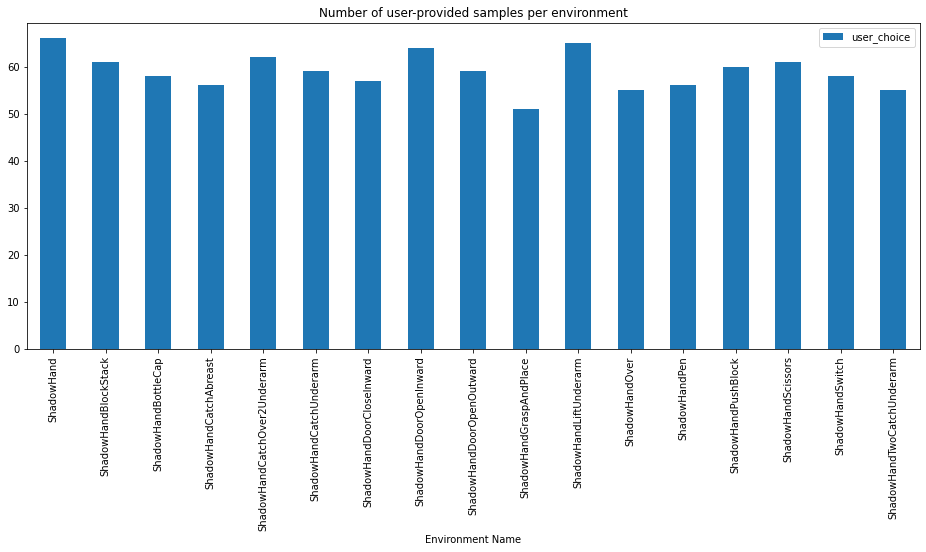

In [93]:
count_group_df.iloc[:, 0:1].plot.bar(figsize=(16,6), stacked=True, xlabel='Environment Name', title='Number of user-provided samples per environment')

## User choice distribution

In [94]:
all_choices = df.user_choice.unique()
all_choices = [x for x in all_choices if str(x) != 'nan']
print(all_choices)


['Left', 'Right', 'Not Sure']


In [95]:
choice_df = df.groupby('env_name')['user_choice'].apply(list).reset_index(name='user_choice')   

choices = {}
for choice in all_choices:
    c_list = []
    for env in all_envs:
        choice_cnts = df.loc[(df['env_name']==env) & (df['user_choice']==choice)].count()
        c_list.append(choice_cnts[0])
        # print(env, choice, choice_cnts[0])
    choices[choice] = c_list
    choice_df[choice] = c_list

print(choice_df.head(5))


                       env_name  \
0                    ShadowHand   
1          ShadowHandBlockStack   
2           ShadowHandBottleCap   
3        ShadowHandCatchAbreast   
4  ShadowHandCatchOver2Underarm   

                                         user_choice  Left  Right  Not Sure  
0  [Not Sure, Left, Not Sure, Right, Not Sure, Le...    12     12        42  
1  [Not Sure, Left, Not Sure, Not Sure, Not Sure,...    14      9        38  
2  [Not Sure, Not Sure, Right, Not Sure, Left, No...    12     16        30  
3  [Left, Not Sure, Not Sure, Not Sure, Not Sure,...     8     10        38  
4  [Not Sure, Not Sure, Not Sure, Right, Left, No...    14     17        31  


                              Left  Right  Not Sure
env_name                                           
ShadowHand                      12     12        42
ShadowHandBlockStack            14      9        38
ShadowHandBottleCap             12     16        30
ShadowHandCatchAbreast           8     10        38
ShadowHandCatchOver2Underarm    14     17        31


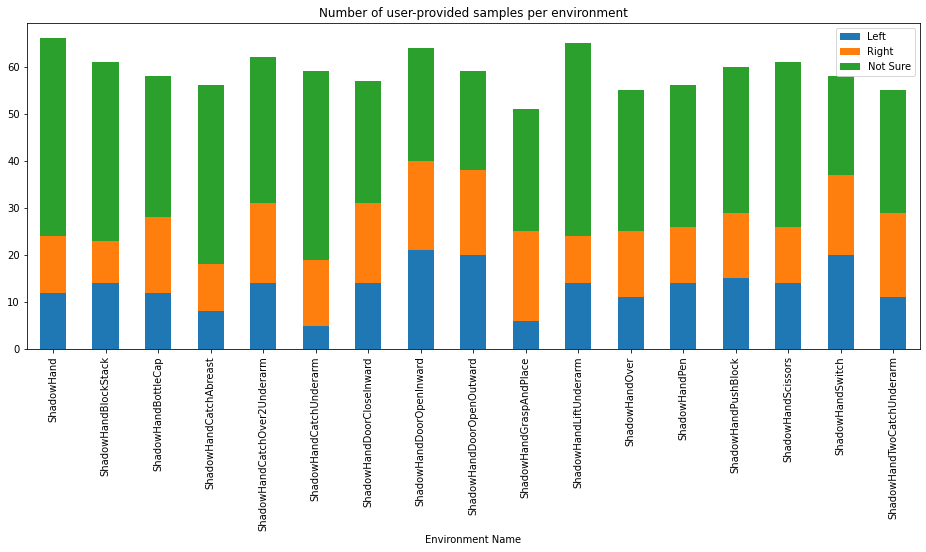

In [96]:
choice_df_plot = choice_df.drop('user_choice', axis=1).set_index('env_name')
print(choice_df_plot.head(5))
fig = choice_df_plot.plot.bar(figsize=(16,6), stacked=True, xlabel='Environment Name', title='Number of user-provided samples per environment').get_figure()
fig.savefig('choice_distribution.png', facecolor='white', bbox_inches='tight', dpi=600)


## Data process for reward model

In [8]:
from pathlib import Path
import pickle
import numpy as np

def get_traj_from_video(video_info):
    traj = None
    video_name = video_info.split('/')[-1]
    traj_name = video_name.replace('.mp4', '.pkl')
    traj_name = traj_name.replace('video', 'traj')
    data_path = 'robotinder/robotinder-data/google_drive_data/raw/'
    try:
        traj_file_path = list(Path(data_path).rglob(traj_name))[0]
        with open(traj_file_path, 'rb') as f:
            traj = pickle.load(f)
    except:
        print("Trajectory data for {} is not found.".format(video_name))
    return traj

# Observation space:
# Index       Description
# 0 - 23	    right shadow hand dof position
# 24 - 47	    right shadow hand dof velocity
# 48 - 71	    right shadow hand dof force
# 72 - 136	right shadow hand fingertip pose, linear velocity, angle velocity (5 x 13)
# 137 - 166	right shadow hand fingertip force, torque (5 x 6)
# 167 - 169	right shadow hand base position
# 170 - 172	right shadow hand base rotation
# 173 - 198	right shadow hand actions
# 199 - 222	left shadow hand dof position
# 223 - 246	left shadow hand dof velocity
# 247 - 270	left shadow hand dof force
# 271 - 335	left shadow hand fingertip pose, linear velocity, angle velocity (5 x 13)
# 336 - 365	left shadow hand fingertip force, torque (5 x 6)
# 366 - 368	left shadow hand base position
# 369 - 371	left shadow hand base rotation
# 372 - 397	left shadow hand actions

def data_process(traj, env):
    # process observation
    if env == 'ShadowHandOver':
        right_hand_obs_idx = np.arange(24).tolist()
        left_hand_obs_idx = np.arange(187, 211).tolist()
    elif env == 'ShadowHand':
        right_hand_obs_idx = np.arange(24).tolist()  # only right hand
        left_hand_obs_idx = []
    else:
        right_hand_obs_idx = np.arange(24).tolist()
        left_hand_obs_idx = np.arange(199, 223).tolist()
    obs_idx = right_hand_obs_idx + left_hand_obs_idx
    # prcess action
    if env == 'ShadowHandOver':
        right_hand_action_idx = np.arange(20).tolist()  # only care 20 joints on hand
        left_hand_action_idx = np.arange(20, 40).tolist()
    elif env == 'ShadowHand':
        right_hand_action_idx = np.arange(20).tolist()  # only care 20 joints on hand
        left_hand_action_idx = []
    else:
        right_hand_action_idx = np.arange(6, 26).tolist()  # only care 20 joints on hand
        left_hand_action_idx = np.arange(32, 52).tolist()
    action_idx = right_hand_action_idx + left_hand_action_idx
    obs = np.array(traj['obs']).squeeze()[:, obs_idx]  # (episode_length, dim)
    action = np.array(traj['actions']).squeeze()[:, action_idx]
    # print(obs.shape, action.shape)
    return obs, action


for index, row in df.iterrows():
    print(f"sample: ({index}, {row['env_name']}, {row.user_choice})")
    videos_name = [row.left_video, row.right_video]
    for side, video in zip(['left', 'right'], videos_name):
        traj = get_traj_from_video(video)
        if traj is not None:
            # print(traj.keys())
            obs, action = data_process(traj, row['env_name'])
            print(f"{side}:, ori obs shape:{np.array(traj['obs']).shape}, proc obs shape: {obs.shape}, action shape: {action.shape}")


# traj = get_traj_from_video(row)
# print(traj.keys())

sample: (0, ShadowHand, nan)
left:, ori obs shape:(472, 1, 211), proc obs shape: (472, 24), action shape: (472, 20)
right:, ori obs shape:(190, 1, 211), proc obs shape: (190, 24), action shape: (190, 20)
sample: (1, ShadowHandCatchUnderarm, nan)
left:, ori obs shape:(75, 1, 422), proc obs shape: (75, 48), action shape: (75, 40)
right:, ori obs shape:(75, 1, 422), proc obs shape: (75, 48), action shape: (75, 40)
sample: (2, ShadowHandCatchAbreast, nan)
left:, ori obs shape:(150, 1, 422), proc obs shape: (150, 48), action shape: (150, 40)
right:, ori obs shape:(150, 1, 422), proc obs shape: (150, 48), action shape: (150, 40)
sample: (3, ShadowHandGraspAndPlace, Right)
left:, ori obs shape:(300, 1, 425), proc obs shape: (300, 48), action shape: (300, 40)
Trajectory data for ShadowHandGraspAndPlace_ppo_7_20221222003342_12000_video-episode-3.mp4 is not found.
sample: (4, ShadowHandOver, Right)
left:, ori obs shape:(75, 1, 398), proc obs shape: (75, 48), action shape: (75, 40)
right:, ori ob

In [63]:
np.arange(10, 13)

array([10, 11, 12])